# IBM Advanced Data Science Capstone Project
## Sentiment Analysis of Amazon Customer Reviews
### Harsh V Singh, Apr 2021

## Feature Engineering

This notebook contains the comprehensive step-by-step process used for cleaning and preparing the raw data. 

1. Since the training data is quite large, we will conduct the initial data exploration and analysis on a sample set of ~10,000 rows. Once we have finalized the ETL steps, we will implement them onto the entire train and test sets.

2. As part of data exploration, we will look at the distribution of heading and review text lengths and number of words. We will also look at the most common words in the review texts, both for stopwords and other words.

3. As part of data processing, we will use the **nltk** package to remove stopwords, clean and tokenize the text, and lemmatize the token words. 

4. Our **target variable** will be a transformation of the review ratings. Ratings above 3 (i.e. 4/5) will be categorized as positive while ratings below 3 will be categorized as negative. *For the purpose of sentiment analysis, we will ignore all reviews with rating 3 as their categorization is ambiguous*.

5. Lastly, we will convert the tokenized word arrays into TFIDF-based sparse vectors which will be used as our final feature sets.

## Importing required Python libraries and initializing Apache Spark environment

In [1]:
import numpy as np
import pandas as pd
import math
import time
from pathlib import Path
import pickle
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns
from wordcloud import WordCloud
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pyarrow

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import string
from langdetect import detect, detect_langs

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from collections import defaultdict
from collections import Counter

nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)
ENGLISH_STOP_WORDS = set(stopwords.words("english"))

import findspark
findspark.init()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType, ArrayType
from pyspark.sql.functions import udf, rand, col, concat, coalesce
from pyspark.ml.feature import HashingTF, IDF, Word2Vec, Word2VecModel

conf = SparkConf().setMaster("local[*]") \
    .setAll([("spark.driver.memory", "24g"),\
             ("spark.executor.memory", "24g"), \
             ("spark.driver.maxResultSize", "24g"), \
             ("spark.executor.heartbeatInterval", "3600s"), \
             ("spark.network.timeout", "7200s")])
sc = SparkContext.getOrCreate(conf=conf)
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()

SAMPLE_SIZE = 5e4 # Subset of training data will be used for exploration
ROWS_PER_PARTITION = 10e3
SEED_NUMBER = 1324
RUN_SAMPLE_CODE = True
RUN_SPARK_CODE = True
SAVE_OUTPUT = True
NUM_FEATURES = 2**15

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Function to print time taken by a particular process, given the start and end times
def printElapsedTime(startTime, endTime):
    elapsedTime = endTime - startTime
    print("-- Process time = %.2f seconds --"%(elapsedTime))

## Loading raw data

We will begin the data preprocessing by loading the raw data.

In [3]:
# Schema that defines the columns and datatypes of the data in the csv files
rawSchema = StructType([
    StructField("rating", IntegerType(), True),
    StructField("review_heading", StringType(), True),
    StructField("review_text", StringType(), True)
    ])

In [4]:
# Function to read a parquet file into a Spark dataframe
# If the parquet file is not found, it will be created from the original csv
def readSparkDFFromParquet(csvPath, parqPath, rawSchema, printTime=False):
    parquetFile = Path(parqPath)
    if (parquetFile.is_file() == False):
        print("Parquet file not found... converting %s to parquet!"%(csvPath))
        savePandasDFToParquet(csvPath=csvPath, parqPath=parqPath, rawSchema=rawSchema, printTime=printTime)
    sparkDF = spark.read.parquet(parqPath)
    return (sparkDF)

In [5]:
def readRawData(csvPath, parqPath, rawSchema, limitRows=None, printTime=True):
    dataRaw = readSparkDFFromParquet(csvPath=csvPath, parqPath=parqPath, rawSchema=rawSchema, printTime=printTime)
    if limitRows is not None:
        dataRaw = dataRaw.orderBy(rand(seed=SEED_NUMBER)).limit(int(limitRows))
    rowCount = dataRaw.count()
    numPartitions = math.ceil(rowCount / ROWS_PER_PARTITION)
    dataRaw = dataRaw.repartition(numPartitions)
    print("There are %d row in the %s partitioned into %d parts."%(rowCount, parqPath, numPartitions))
    return (dataRaw)

In [6]:
trainRaw = readRawData(csvPath="data/raw/train.csv", parqPath="data/train.parquet", rawSchema=rawSchema, printTime=True)
testRaw = readRawData(csvPath="data/raw/test.csv", parqPath="data/test.parquet", rawSchema=rawSchema, printTime=True)

There are 3000000 row in the data/train.parquet partitioned into 300 parts.
There are 650000 row in the data/test.parquet partitioned into 65 parts.


Since the training dataset is quite large, we will conduct the data exploration and analysis on a sample set, whose size is defined as a global variable, **ETL_SAMPLE_SIZE**. We will convert this to a Pandas dataframe for the analysis.

In [7]:
if RUN_SAMPLE_CODE:
    sampleRaw = trainRaw.limit(int(SAMPLE_SIZE)).toPandas()
    print("There are %d samples in the training data."%(sampleRaw.shape[0]))

There are 50000 samples in the training data.


## Data exploration

First, we should find and remove any rows with null values in the sample data. We also need to ensure that the entire training dataset consists only of **English** language reviews. We will use the **langdetect** package to check that and drop all the training data rows where language is not *en*.

In [8]:
if RUN_SAMPLE_CODE:
    sampleRaw.dropna(axis=0, inplace=True)
    print("After removing empty/ null values, there are %d samples in the training data."%(sampleRaw.shape[0]))

After removing empty/ null values, there are 50000 samples in the training data.


In [9]:
# Function that call the detect function in langdetect package to predict the language of a given text
def detectTextLanguage(text):
    try:
        lang = detect(text)
    except:
        lang = "error"
    return lang

In [10]:
if RUN_SAMPLE_CODE:
    startTime = time.time()
    sampleRaw["lang"] = sampleRaw.apply(lambda x: detectTextLanguage(x["review_text"]), axis=1)
    sampleRaw.drop(sampleRaw[sampleRaw["lang"] != "en"].index, inplace=True)
    sampleRaw.drop(columns="lang", inplace=True)

    print("There are %d samples left after dropping non-english language reviews."%(sampleRaw.shape[0]))
    endTime = time.time()
    printElapsedTime(startTime=startTime, endTime=endTime)

There are 49895 samples left after dropping non-english language reviews.
-- Process time = 154.17 seconds --


In [11]:
# Function that plots multiple customized histograms given certain datasets  
def plotHistograms(datasets, titles, figTitle, figSize=(18,6), numCols=1, binWidth=1):
    fig = plt.figure(figsize=figSize)
    sns.set_theme()
    sns.set_style("white")
    
    numRows = math.ceil(len(datasets) / numCols)
    for i in range(len(datasets)):
        fig.add_subplot(numRows, numCols, i+1)
        sns.histplot(data=datasets[i], binwidth=binWidth)
        plt.xlabel("")
        plt.ylabel("")
        plt.title(titles[i])
    
    fig.suptitle(figTitle)
    plt.show()

We will plot histograms in order to visualize the length of the review heading and text. Similarly, we will also look at the distribution for number of words in the headings and review texts.

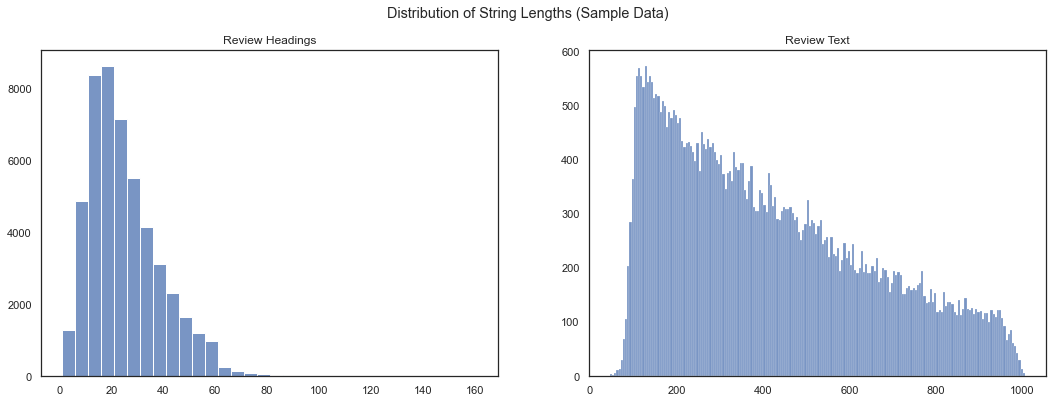

In [12]:
if RUN_SAMPLE_CODE:
    plotHistograms(
        datasets=[
            sampleRaw['review_heading'].str.len(),
            sampleRaw['review_text'].str.len()],
        titles=["Review Headings", "Review Text"],
        figTitle="Distribution of String Lengths (Sample Data)",
        figSize=(18,6), numCols=2, binWidth=5
    )

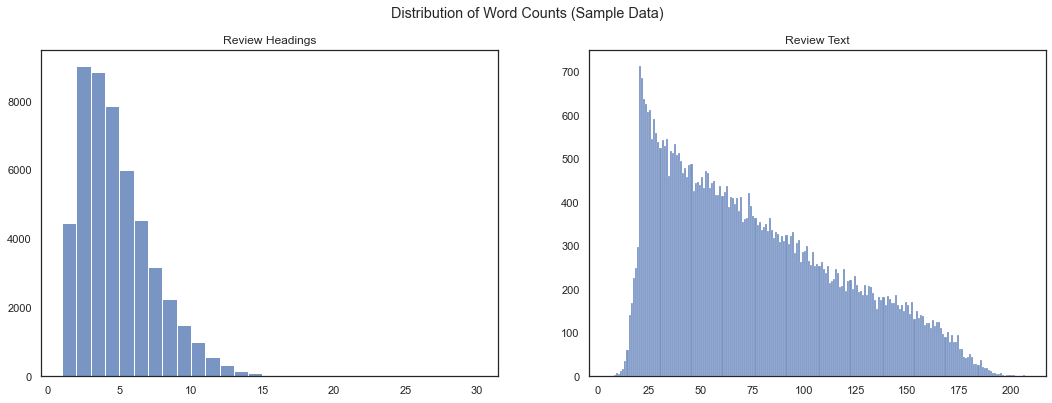

In [13]:
if RUN_SAMPLE_CODE:
    plotHistograms(
        datasets=[
            sampleRaw['review_heading'].str.split().map(lambda x: len(x)),
            sampleRaw['review_text'].str.split().map(lambda x: len(x))
            ],
        titles=["Review Headings", "Review Text"],
        figTitle="Distribution of Word Counts (Sample Data)",
        figSize=(18,6), numCols=2, binWidth=1
    )

## Data cleansing and pre-processing


In [14]:
# Function that returns the top N most common words and their counts
def getSortedWordCounts(wordCounts, topN=0):
    sortedCounts = [[k, v] for k, v in sorted(wordCounts.items(), key=lambda item: -item[1])]
    sortedCounts = pd.DataFrame(sortedCounts, columns = ["word", "count"]) 
    if(topN > 0):
        sortedCounts = sortedCounts.head(min(topN, sortedCounts.shape[0]))
    return (sortedCounts)


In [15]:
# Function that uses word_tokenize from the nltk package to convert text strings into word tokens
# This function also cleans the token words by removing any punctuation and only keeps words which contain alphabets 
def getWordTokensFromText(textData):
    rawTokens = word_tokenize(textData)
    cleanTokens = [w.lower().translate(str.maketrans('', '', string.punctuation)) for w in rawTokens]
    wordList = [word for word in cleanTokens if word.isalpha()]
    return (wordList)

In [16]:
# Function that takes as input a list of words and their counts to return the most common stopwords and other words in the list
def getTopWords(wordList, stopWords, topN=25):
    stopCounts = defaultdict(int)
    otherCounts = defaultdict(int)
    for word in wordList:
        if word in stopWords:
            stopCounts[word] += 1
        else:
            otherCounts[word] += 1

    topStopWords = getSortedWordCounts(stopCounts, topN)
    topOtherWords = getSortedWordCounts(otherCounts, topN)

    return ({"stopWords": topStopWords, "otherWords": topOtherWords})

In [17]:
# Creating a copy of the sample data to convert the text into tokenized word arrays
if RUN_SAMPLE_CODE:
    sampleTokenized = sampleRaw.copy(deep=True)
    sampleTokenized["review_heading"] = [getWordTokensFromText(text) for text in sampleTokenized["review_heading"]]
    sampleTokenized["review_text"] = [getWordTokensFromText(text) for text in sampleTokenized["review_text"]]

    headingWords = sampleTokenized["review_heading"].apply(pd.Series).stack().reset_index(drop = True).to_list()
    textWords = sampleTokenized["review_text"].apply(pd.Series).stack().reset_index(drop = True).to_list()

    # Get the list fo most common heading/ text words (stopwords and others)
    topHeadingWords = getTopWords(wordList=headingWords, stopWords=ENGLISH_STOP_WORDS, topN=25)
    topTextWords = getTopWords(wordList=textWords, stopWords=ENGLISH_STOP_WORDS, topN=25)

    print("There are %d words in the review texts of %d samples."%(len(textWords), sampleTokenized.shape[0]))

There are 3817051 words in the review texts of 49895 samples.


In [18]:
# Function that plots multiple custom horizontal bar plots
def plotBars(datasets, titles, x, y, figTitle, figSize=(12,6), numCols=1):
    fig = plt.figure(figsize=figSize)
    sns.set_theme()
    sns.set_style("white")
    
    numRows = math.ceil(len(datasets) / numCols)
    for i in range(len(datasets)):
        fig.add_subplot(numRows, numCols, i+1)
        sns.barplot(data=datasets[i], x=y, y=x)
        plt.xlabel("")
        plt.ylabel("")
        plt.title(titles[i])
    fig.suptitle(figTitle)
    plt.show()

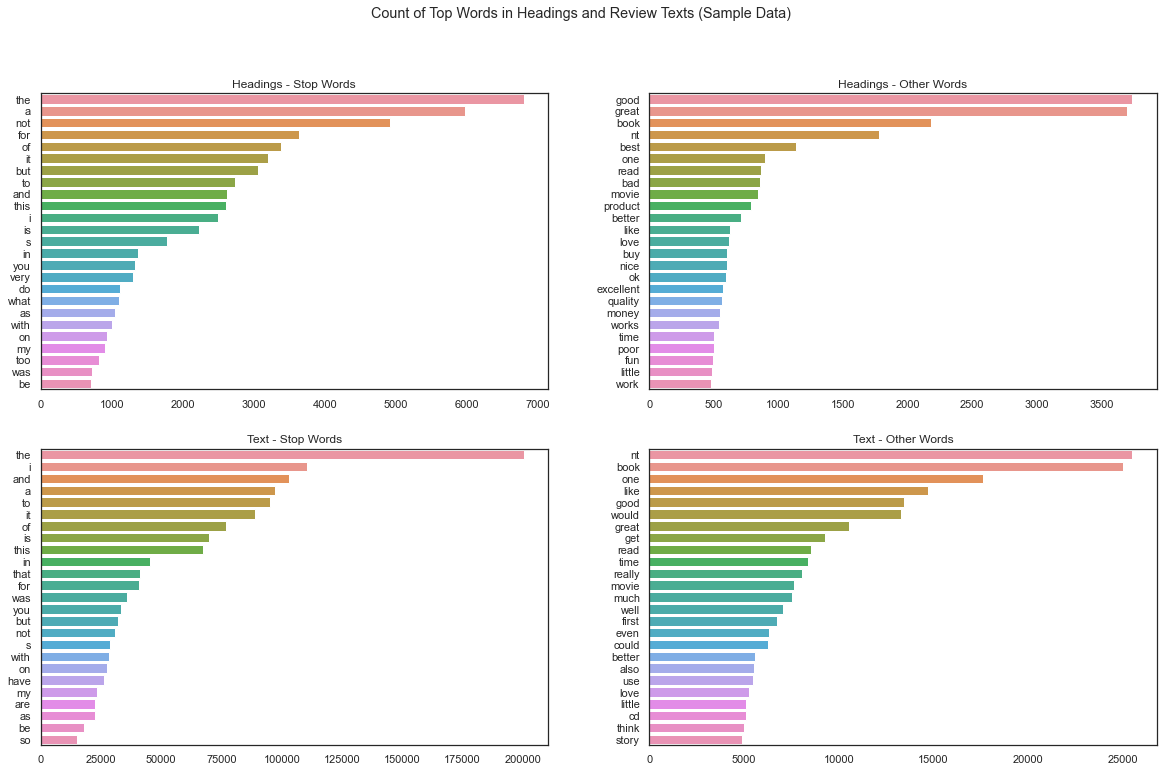

In [19]:
if RUN_SAMPLE_CODE:
    plotBars(
        datasets=[topHeadingWords["stopWords"], topHeadingWords["otherWords"], topTextWords["stopWords"], topTextWords["otherWords"]], 
        titles=["Headings - Stop Words", "Headings - Other Words", "Text - Stop Words", "Text - Other Words"],
        x="word", y="count", 
        figTitle="Count of Top Words in Headings and Review Texts (Sample Data)", 
        figSize=(20,12), numCols=2)

We can visualize the words present in the reviews by creating a word cloud using the **WordCloud** package.

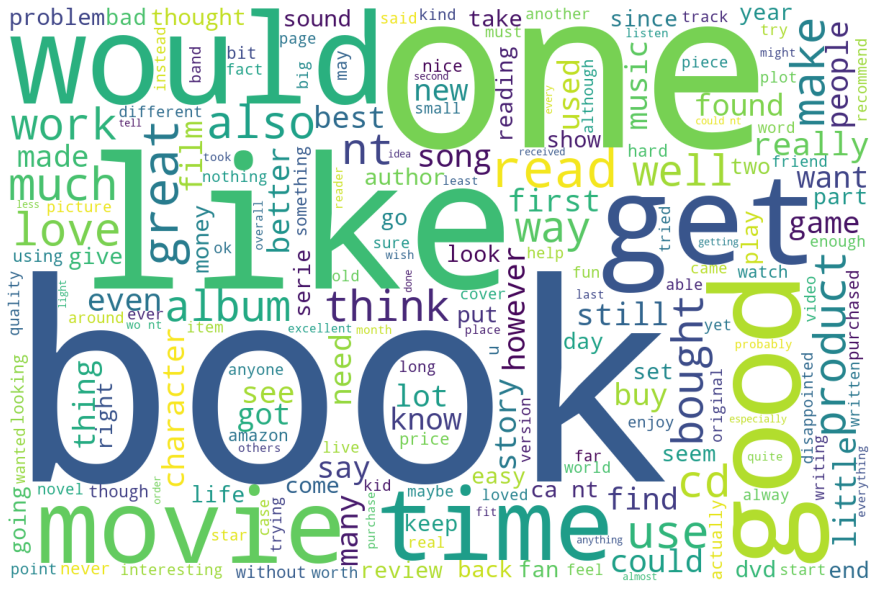

In [20]:
# Create a word cloud of the words in the review texts after removing stop words
wordcloud = WordCloud(width = 1200, height = 800, background_color ='white', stopwords=ENGLISH_STOP_WORDS, min_font_size = 10).generate(" ".join(textWords))
# Plot the WordCloud image
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

Next, we will process the tokenized data by combining the token words in the headings and review texts into a single column called **review_content**. We will also categorize all the data into positive/ negative sentiment reviews. All reviews with ratings more than 3 will be categorized as positive while all reviews with ratings less than 3 will be categorized as negative.

*We will drop all the rows where review rating is 3 as they are ambiguous in terms of the customers sentiment.*

In [21]:
def getReviewSentiment(rating):
    sentiment = None
    if(rating > 3):
        sentiment = 1
    elif(rating < 3):
        sentiment = 0
    return (sentiment)

In [22]:
if RUN_SAMPLE_CODE:
    sampleProcessed = sampleTokenized.copy()
    sampleProcessed["review_content"] = sampleProcessed["review_heading"] + sampleProcessed["review_text"]
    sampleProcessed["review_sentiment"] = [getReviewSentiment(rating) for rating in sampleProcessed["rating"]]
    
    sampleProcessed.drop(columns=["review_heading", "review_text", "rating"], inplace=True)
    sampleProcessed.dropna(axis=0, inplace=True)

## Dimensionality reduction - Removing stop words + Lemmatization

In order to reduce the dimensionality of the feature set and also reduce the noise in the training data, we will remove all the stop words from **review_content**. 

In [23]:
# Function to remove stopwords from a given array of words
def removeStopWordsFromText(textData, stopWords):
    relevantText = [word for word in textData if word not in stopWords]
    return (relevantText)

In [24]:
if RUN_SAMPLE_CODE:
    sampleProcessed["review_content"] = [removeStopWordsFromText(text, ENGLISH_STOP_WORDS) for text in sampleProcessed["review_content"]]

Now that we have a list of relevant words from each review, we will convert these words into their respective *lemmas*. This process is known as **Lemmatisation** in linguistics and is the process of grouping together the inflected forms of a word so they can be analysed as a single item. For example, variations of the word run such as ran, running, runs, etc. will all be replaced with the dictionary form of the word, i.e., run. This will further help in reducing the dimensionality of the feature set.  

In [25]:
# Function that returns the NOUN form of any given word, using wordnet data from the nltk package
def getWordnetPos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tagDictionary = {
      "J": "a", #wordnet.ADJ,
      "N": "n", #wordnet.NOUN,
      "V": "v", #wordnet.VERB,
      "R": "r", #wordnet.ADV
      }
  return (tagDictionary.get(tag, "n")) #wordnet.NOUN))

# Function that returns the lemmatized version of the text, i.e. replacing each word with its lemma
def getLemmatizedText(textData, lemmatizer):
  lemText = [lemmatizer.lemmatize(word, getWordnetPos(word)) for word in textData]
  return (lemText)

In [26]:
if RUN_SAMPLE_CODE:
    startTime = time.time()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    sampleProcessed["review_content"] = [getLemmatizedText(text, lemmatizer) for text in sampleProcessed["review_content"]]
    endTime = time.time()
    printElapsedTime(startTime=startTime, endTime=endTime)

-- Process time = 646.26 seconds --


### Method 1: Vectorized sparse matrix as features

In the first method, we will vectorize the tokens into a sparse matrix using TFIDF Vectorizer from the **scikit-learn** package. This will create a list of features in the form of a sparse array containing the relative count of each word in a particular review. In this method, the sequential ordering of words is lost.

In [27]:
if RUN_SAMPLE_CODE:
    tfVect = TfidfVectorizer()
    tfData = tfVect.fit_transform(sampleProcessed["review_content"].apply(" ".join))
    print("Review texts are transformed into a %s with %s elements."%(type(tfData), tfData.shape, ))

Review texts are transformed into a <class 'scipy.sparse.csr.csr_matrix'> with (39915, 75622) elements.


We will split this data into training and test sets and save them to disk.

In [28]:
if RUN_SAMPLE_CODE:
    X_train, X_test, y_train, y_test = train_test_split(tfData, sampleProcessed["review_sentiment"], test_size=0.2, random_state=SEED_NUMBER)

    if SAVE_OUTPUT:
        Path("data/sample/tfData").mkdir(parents=True, exist_ok=True)
        sparse.save_npz("data/sample/tfData/X_train.npz", X_train)
        sparse.save_npz("data/sample/tfData/X_test.npz", X_test)
        y_train.to_csv("data/sample/tfData/y_train.csv", index=False)
        y_test.to_csv("data/sample/tfData/y_test.csv", index=False)

### Method 2: Padded sequential word vectors as features

In this method, we will simply convert the review text string into a sequenced array with padding added to make all review vectors of the same length. We will use the **tensorflow** package for this.

In [29]:
def getPaddedFeatureVectors(textData, tokenizer, maxSeqLength):
    # Convert list of words to list of ints
    sequence = tokenizer.texts_to_sequences([textData])
    # Make all sequences of the same length by padding zeros
    paddedSeq = pad_sequences(sequence, maxlen=maxSeqLength, padding="pre")[0]
    paddedSeq = [x.item() for x in paddedSeq]
    return (paddedSeq)

In [30]:
if RUN_SAMPLE_CODE:
    # Tokenize the review_content using tensorflow Tokenizer
    sampleTokenizer = Tokenizer(num_words=NUM_FEATURES)
    sampleTokenizer.fit_on_texts(sampleProcessed["review_content"].apply(lambda x: " ".join(x)))
    # Get the length of the longest sequence and add padding to the other vectors accordingly
    maxSeqLength = max(len(s) for s in sampleProcessed["review_content"])
    seqData = sampleProcessed["review_content"].apply(lambda x: getPaddedFeatureVectors(x, sampleTokenizer, maxSeqLength))

We will split this data into training and test sets and save them to disk.

In [31]:
if RUN_SAMPLE_CODE:
    X_train, X_test, y_train, y_test = train_test_split(seqData, sampleProcessed["review_sentiment"], test_size=0.2, random_state=SEED_NUMBER)

    if SAVE_OUTPUT:
        Path("data/sample/seqData").mkdir(parents=True, exist_ok=True)
        np.save("data/sample/seqData/X_train.npy", X_train)
        np.save("data/sample/seqData/X_test.npy", X_test)
        y_train.to_csv("data/sample/seqData/y_train.csv", index=False)
        y_test.to_csv("data/sample/seqData/y_test.csv", index=False)

## Preprocessing training set using Spark

Now that we have completed the preprocessing of the sample data, we will apply the same steps to the entire dataset. Since we are dealing with a relatively large dataset of ~3M rows, we will use Spark in order to reduce the time required to prepare the training data.

### Cleaning and preprocessing text reviews -

1. Remove null/ NaN rows from the dataset
2. Transform ratings into a binary column by assigning 0 (negative) to *rating < 3* and 1 (positive) to *rating > 3*
3. Drop all rows where *rating = 3*
4. Remove non-English language reviews
5. Remove punctuations and tokenize the words in review headings and text
6. Combine heading and text tokens into a single column
7. Remove stop words from tokenized words
8. Lemmatize the remaining words

In [32]:
# Defining User-defined functions for Spark 

langDetectUDF = udf(lambda x: detectTextLanguage(x), StringType())

wordTokensUDF = udf(lambda x: getWordTokensFromText(x), ArrayType(StringType()))

def removeStopWordsUDF(stopWords):
    return udf(lambda x: removeStopWordsFromText(x, stopWords), ArrayType(StringType()))

def lemmaTextUDF(lemmatizer):
    return udf(lambda x: getLemmatizedText(x, lemmatizer), ArrayType(StringType()))

reviewSentimentUDF = udf(lambda x: getReviewSentiment(x), IntegerType())

def paddedVectorsUDF(tokenizer, maxSeqLength):
    return udf(lambda x: getPaddedFeatureVectors(x, tokenizer, maxSeqLength), ArrayType(IntegerType()))

getArrayLengthUDF = udf(lambda x: len(x), IntegerType())

concatWordArrayUDF = udf(lambda x: " ".join(x), StringType())

In [33]:
def preProcessRawData(dataRaw):
    
    # Remove null/ NaN rows
    print("-- Removing null/ NaN rows --")
    dataClean = dataRaw.dropna()

    # Transform rating into positive/ negative sentiment
    print("-- Transforming rating into positive/ negative sentiment --")
    dataClean = dataClean.withColumn("review_sentiment", reviewSentimentUDF("rating"))

    # Drop all rows with sentiment = None
    print("-- Dropping all rows with sentiment = None --")
    dataClean = dataClean.filter(dataClean["review_sentiment"].isNotNull())

    # Remove non-English reviews
    print("-- Removing non-English reviews --")
    dataClean = dataClean.withColumn("lang", langDetectUDF("review_text"))
    dataClean = dataClean.filter(dataClean["lang"] == "en")
    dataClean = dataClean.drop("lang")

    # Remove punctuations and tokenize words in review_heading and review_text
    print("-- Removing punctuations and tokenize words in review_heading and review_text --")
    dataClean = dataClean.withColumn("token_heading", wordTokensUDF("review_heading"))
    dataClean = dataClean.withColumn("token_text", wordTokensUDF("review_text"))

    # Combine heading and text into single column
    print("-- Combining heading and text into single column --")
    dataClean = dataClean.withColumn("token_content", concat(col("token_heading"), col("token_text")))

    # Remove all stop words 
    print("-- Removing all stop words --")
    dataClean = dataClean.withColumn("token_content_no_stops", removeStopWordsUDF(ENGLISH_STOP_WORDS)(col("token_content")))

    # Lemmatize remaining words 
    print("-- Lemmatizing remaining words --")
    lemmatizer = nltk.stem.WordNetLemmatizer()
    dataClean = dataClean.withColumn("token_content_lemma", lemmaTextUDF(lemmatizer)(col("token_content_no_stops")))

    # Concatenate word arrays into strings
    print("-- Concatenating word arrays into strings --")
    dataClean = dataClean.withColumn("str_content_lemma", concatWordArrayUDF(col("token_content_lemma")))

    dataClean = dataClean.select("token_content_lemma", "str_content_lemma", "review_sentiment")
    return (dataClean)

In [34]:
def saveCleanData(dataClean, parqPath):
    try:
        startTime = time.time()
        if SAVE_OUTPUT:
            dataClean.write.parquet(parqPath, mode="overwrite")
        endTime = time.time()
        print("-- Saved clean data to %s --" % (parqPath))
        printElapsedTime(startTime=startTime, endTime=endTime)
    except Exception as e:
        print(e)

In [35]:
if RUN_SPARK_CODE:
    trainClean = preProcessRawData(trainRaw)
    #saveCleanData(trainClean, "data/trainClean.parquet")

-- Removing null/ NaN rows --
-- Transforming rating into positive/ negative sentiment --
-- Dropping all rows with sentiment = None --
-- Removing non-English reviews --
-- Removing punctuations and tokenize words in review_heading and review_text --
-- Combining heading and text into single column --
-- Removing all stop words --
-- Lemmatizing remaining words --
-- Concatenating word arrays into strings --


In [36]:
# Write trainData to disk
if RUN_SPARK_CODE:
    testClean = preProcessRawData(testRaw)
    #saveCleanData(testClean, "data/testClean.parquet")

-- Removing null/ NaN rows --
-- Transforming rating into positive/ negative sentiment --
-- Dropping all rows with sentiment = None --
-- Removing non-English reviews --
-- Removing punctuations and tokenize words in review_heading and review_text --
-- Combining heading and text into single column --
-- Removing all stop words --
-- Lemmatizing remaining words --
-- Concatenating word arrays into strings --


### Method 1: Sparse matrix as features

In [37]:
def featurizeUsingTFIDF(dataClean, parqPath, hashingTF=None, idfModel=None):
    
    print("Vectorizing the lemmatized words into a sparse featureset")
    startTime = time.time()

    if hashingTF is None:
        hashingTF = HashingTF(inputCol="token_content_lemma", outputCol="raw_features", numFeatures=NUM_FEATURES)
    featurizedData = hashingTF.transform(dataClean)

    if idfModel is None:
        idf = IDF(inputCol="raw_features", outputCol="features")
        idfModel = idf.fit(featurizedData)
    
    rescaledData = idfModel.transform(featurizedData)
    dataTF = rescaledData.select("features", "review_sentiment")
    if SAVE_OUTPUT:
        dataTF.write.parquet(parqPath, mode="overwrite")

    endTime = time.time()
    print("-- Saved featurized data to %s --" % (parqPath))
    printElapsedTime(startTime=startTime, endTime=endTime)

    return (hashingTF, idfModel)

In [38]:
# Vectorize the lemmatized words into a sparse featureset
if False:
    hashingTF, idfModel = featurizeUsingTFIDF(dataClean=trainClean, parqPath="data/trainTF.parquet")
    _, _ = featurizeUsingTFIDF(dataClean=testClean, parqPath="data/testTF.parquet", hashingTF=hashingTF, idfModel=idfModel)

### Method 2: Padded vectors as features

In [39]:
def featurizeUsingPaddedVectors(dataClean, parqPath, modelPath, tokenizer=None, maxSeqLength=None, saveModel=True):
    
    print("Vectorizing the lemmatized words into padded vector features")
    startTime = time.time()
    
    # Train a Keras Tokenizer model that will replace each word in our data with a integer
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=NUM_FEATURES)
        contentStrings = dataClean.select("str_content_lemma").toPandas()
        tokenizer.fit_on_texts(contentStrings["str_content_lemma"])
    
    # Get the length of the longest sentence/ review in the data
    if maxSeqLength is None:
        maxSeqLength = dataClean.withColumn("array_len", getArrayLengthUDF(col("token_content_lemma"))).groupby().max("array_len").collect()[0][0]
    
    dataSeq = dataClean.withColumn("features", paddedVectorsUDF(tokenizer, maxSeqLength)(col("token_content_lemma")))
    dataSeq = dataSeq.select("features", "review_sentiment")

    if SAVE_OUTPUT:
        if saveModel:
            with open(modelPath, "wb") as handle:
                pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        dataSeq.write.parquet(parqPath, mode="overwrite")

    endTime = time.time()
    print("-- Saved data to %s --" % (parqPath))
    printElapsedTime(startTime=startTime, endTime=endTime)

    return (tokenizer, maxSeqLength)

In [40]:
# Vectorize the lemmatized words into padded integer vectors
if RUN_SPARK_CODE:
    finalTokenizer, maxSeqLength = featurizeUsingPaddedVectors(
        trainClean, parqPath="data/trainSeq.parquet", modelPath="data/vectorTokenizer.pickle")

    _, _ = featurizeUsingPaddedVectors(
        testClean, parqPath="data/testSeq.parquet", modelPath="data/vectorTokenizer.pickle",
        tokenizer=finalTokenizer, maxSeqLength=maxSeqLength, saveModel=False)

Vectorizing the lemmatized words into padded vector features
-- Saved data to data/trainSeq.parquet --
-- Process time = 49470.70 seconds --
Vectorizing the lemmatized words into padded vector features
-- Saved data to data/testSeq.parquet --
-- Process time = 3865.68 seconds --


In [41]:
spark.sparkContext.stop()